In [20]:
#0：其他；1：V_ref; 2:S_ref;

import numpy as np
import pandas as pd
import scipy.io
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm

def read_data_physionet_2_clean():
    """
    only N V, S
    """
    # read pkl
    with open('./cpsc2020.pkl', 'rb') as fin:
        res = pickle.load(fin)
    ## scale data
    all_data = res['data']
    for i in range(len(all_data)):
        tmp_data = all_data[i]
        tmp_std = np.std(tmp_data)
        tmp_mean = np.mean(tmp_data)
        if(tmp_std==0):
            tmp_std = 1 
        all_data[i] = (tmp_data - tmp_mean) / tmp_std
    all_data_raw = res['data']
    all_data = []
    ## encode label
    all_label = []
    for i in range(len(res['label'])):
        if res['label'][i] == 1:
            all_label.append(1)
            all_data.append(res['data'][i])
        elif res['label'][i] == 2:
            all_label.append(2)
            all_data.append(res['data'][i])
        else:
            all_label.append(0)
            all_data.append(res['data'][i])       
    all_label = np.array(all_label)
    all_data = np.array(all_data)

    # split train test
    X_train, X_test, Y_train, Y_test = train_test_split(all_data, all_label, test_size=0.1, random_state=15)
    
    # print size
    print('训练数据集中 其他类别(0)；室早(1)；房早(2)的数量: ')
    print(Counter(Y_train), Counter(Y_test))
    
    # shuffle train
    shuffle_pid = np.random.permutation(Y_train.shape[0])
    X_train = X_train[shuffle_pid]
    Y_train = Y_train[shuffle_pid]

    # expend 2 dim
    X_train = np.expand_dims(X_train, 1)
    X_test = np.expand_dims(X_test, 1)

    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = read_data_physionet_2_clean()

训练数据集中 其他类别(0)；室早(1)；房早(2)的数量: 
Counter({1: 8718, 0: 4606, 2: 2561}) Counter({1: 1008, 0: 477, 2: 280})


In [21]:
# 构建数据结构 MyDataset

import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    #把numpy转换为Tensor
    def __getitem__(self, index):
        return (torch.tensor(self.data[index], dtype=torch.float), torch.tensor(self.label[index], dtype=torch.long))

    def __len__(self):
        return len(self.data)

In [26]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 1, 2000)
            nn.Conv1d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this sig after Conv1d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 1, 2000)
            #nn.Tanh(),                      # activation  
            #nn.Sigmoid(),
            #nn.BatchNorm1d(num_features=16),
            nn.Dropout(0.2),#扔到0.2
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5),    # choose max value in 1x5 area, output shape (16, 1, 400)2000/5
        )
        self.conv2 = nn.Sequential(         # input shape (16, 1, 400)
            nn.Conv1d(16, 32, 5, 1, 2),     # output shape (32, 1, 400)
            #nn.Tanh(),                      # activation  
            #nn.Sigmoid(),
            #nn.BatchNorm1d(num_features=32),
            nn.Dropout(0.2),#扔到0.2
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5),                # output shape (32, 1, 400/5=80)
        )
        self.out = nn.Linear(32 *  80, 3)   # fully connected layer, output 3 classes

    def forward(self, x):
        x = self.conv1(x)
        #Swish = x*sigmod(x) swish函数
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 80)
        output = self.out(x)
        #output.Softmax()
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2560, out_features=3, bias=True)
)


start
训练数据集中 其他类别(0)；室早(1)；房早(2)的数量: 
Counter({1: 8718, 0: 4606, 2: 2561}) Counter({1: 1008, 0: 477, 2: 280})
(15885, 1, 2000) (15885,)
CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2560, out_features=3, bias=True)
)
learn rate: 0.001
第 0 次epoch： f1_score: 0.5002441252441252 ,train loss: 0.8177
第 1 次epoch： f1_score: 0.5234943238487338 ,train loss: 0.7025
第 2 次epoch： f1_score: 0.5253615898228653 ,train loss: 0.6286
第 3 次epoch： f1_score: 0.537910951407147 ,train loss: 0.6039
第 4 次epoch： f1_score: 0.5648916709925594 ,train loss: 0.5788
第 5 次

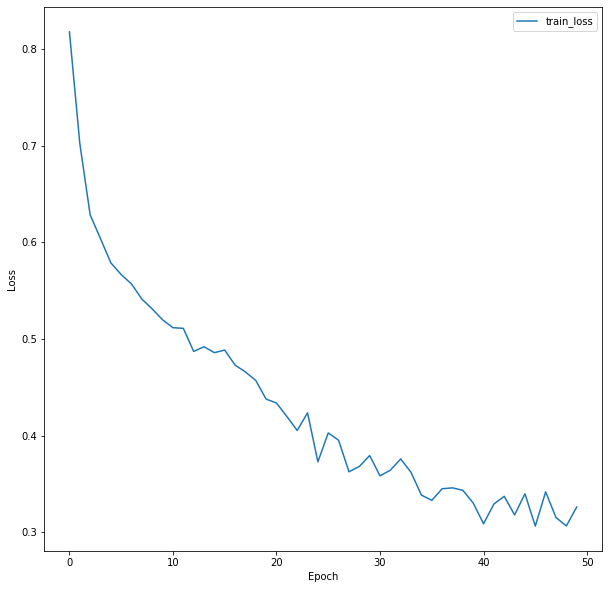

In [27]:
"""
test on cpsc2020 data

Hanshaung Xie, Oct 2020
"""

import numpy as np
import pickle
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter


if __name__ == "__main__":
    is_debug = False
    batch_size = 318
    if is_debug:
        writer = SummaryWriter('/debug')
    else:
        writer = SummaryWriter('/new_novote_cleandata_rerunx')
    # make data
    print('start')
    
    # read data
    X_train, X_test, Y_train, Y_test = read_data_physionet_2_clean()
    print(X_train.shape, Y_train.shape)
    
    #继承Dataset类，自定义数据集以及对应的标签
    dataset = MyDataset(X_train, Y_train)
    dataset_test = MyDataset(X_test, Y_test)
    #装载数据，实现批量读取
    dataloader = DataLoader(dataset, batch_size=batch_size)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, drop_last=False)

    # 是否使用gpu运行
    device_str = "cuda"
    device = torch.device(device_str if torch.cuda.is_available() else "cpu")
    
    # 初始化自定义的模型类
    model = CNN()
    print(model)
    model.to(device)
   
    model.verbose = False#运行的时候不显示详细信息
   
    LR = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)       # optimize all cnn parameters
    loss_func = torch.nn.CrossEntropyLoss()                       # the target label is not one-hotted
    print("learn rate:",LR)
    
    n_epoch = 50
    step = 0
    prev_f1 = 0
    loss_epoch=[]
    #for _ in tqdm(range(n_epoch), desc="epoch", leave=False):
    for epoch in range(n_epoch):
        # train     
        model.train()
        #prog_iter = tqdm(dataloader, desc="Training", leave=False) #显示进度条
        #for batch_idx, (input_x, input_y) in enumerate(dataloader): #两种循环方式，下面的方式更加灵活
        for batch_idx, batch in enumerate(dataloader):    
            #input_x, input_y = tuple(t.to(device) for t in batch) #可以选择使用的CPU或者GPU
            input_x, input_y = tuple(batch)
            #pred = model(input_x)
            #print("pred:",pred) 输出为元胞类型(tensor([[]]))
            pred = model(input_x)[0]
            #print("pred:",pred) 输出为tensor([[]])
            #print("input_y:",input_y) 输出为tensor([])
            loss = loss_func(pred, input_y)
            #print('train loss: %.4f' % loss.data.numpy())
            optimizer.zero_grad()#梯度置零
            loss.backward()
        #optimizer.step()是大多数optimizer所支持的简化版本。一旦梯度被如backward()之类的函数计算好后，就可以调用这个函数更新所有的参数。
            optimizer.step()
            step += 1

            writer.add_scalar('Loss/train', loss.item(), step)
        
        #cheduler.step(_)
                    
        # test
        model.eval()
        #prog_iter_test = tqdm(dataloader_test, desc="Testing", leave=False)
        all_pred_prob = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader_test):
                input_x, input_y = tuple(t.to(device) for t in batch)
                pred = model(input_x)[0]
                all_pred_prob.append(pred)
        all_pred_prob = np.concatenate(all_pred_prob)
        all_pred = np.argmax(all_pred_prob, axis=1)
        ## classification report
        tmp_report = classification_report(Y_test, all_pred, output_dict=True)
        f1_score = (tmp_report['0']['f1-score'] + tmp_report['1']['f1-score']+tmp_report['2']['f1-score'])/3
        if f1_score > prev_f1:
            torch.save(model, 'models/acnn_{}_{:.4f}.pt'.format(_, f1_score))
            prev_f1 = f1_score
        
        writer.add_scalar('f1_score', f1_score, epoch)
        writer.add_scalar('label_0', tmp_report['0']['f1-score'], epoch)
        writer.add_scalar('label_1', tmp_report['1']['f1-score'], epoch)
        print("第",epoch,'次epoch：',"f1_score:",f1_score,',train loss: %.4f' % loss.data.numpy())
        loss_epoch.append(loss.data.numpy())
        if(epoch==n_epoch-1):
            print(confusion_matrix(Y_test, all_pred))
            print(classification_report(Y_test, all_pred))
    #with SummaryWriter(log_dir='logs',comment='Net') as w:
        #w.add_graph(model,(input,))
    plt.figure(figsize=(10,10))
    plt.plot(loss_epoch,label='train_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.draw()
    
